In [1]:
import os
import torch
import pandas as pd
import numpy as np
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from tqdm import tqdm

In [2]:
torch.manual_seed(31337);
device = "cuda" if torch.cuda.is_available() else "cpu"
kwargs = {'num_workers': 2, 'pin_memory': True} if device=='cuda' else {}
print(device)

cuda


In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/Colab Notebooks/archive.zip"

In [5]:
images = torchvision.datasets.ImageFolder("/content/images/Images")

labels = [label for label in images.classes]
print(labels, len(labels))

['n02085620-Chihuahua', 'n02085782-Japanese_spaniel', 'n02085936-Maltese_dog', 'n02086079-Pekinese', 'n02086240-Shih-Tzu', 'n02086646-Blenheim_spaniel', 'n02086910-papillon', 'n02087046-toy_terrier', 'n02087394-Rhodesian_ridgeback', 'n02088094-Afghan_hound', 'n02088238-basset', 'n02088364-beagle', 'n02088466-bloodhound', 'n02088632-bluetick', 'n02089078-black-and-tan_coonhound', 'n02089867-Walker_hound', 'n02089973-English_foxhound', 'n02090379-redbone', 'n02090622-borzoi', 'n02090721-Irish_wolfhound', 'n02091032-Italian_greyhound', 'n02091134-whippet', 'n02091244-Ibizan_hound', 'n02091467-Norwegian_elkhound', 'n02091635-otterhound', 'n02091831-Saluki', 'n02092002-Scottish_deerhound', 'n02092339-Weimaraner', 'n02093256-Staffordshire_bullterrier', 'n02093428-American_Staffordshire_terrier', 'n02093647-Bedlington_terrier', 'n02093754-Border_terrier', 'n02093859-Kerry_blue_terrier', 'n02093991-Irish_terrier', 'n02094114-Norfolk_terrier', 'n02094258-Norwich_terrier', 'n02094433-Yorkshire_t

In [6]:
test_size = int(len(images) * 0.15)
validation_size = int(len(images) * 0.15)
train_size = len(images) - test_size - validation_size
print(f'train size: {train_size}, validation size: {validation_size}, test size: {test_size}')
train_images, validation_images, test_images = torch.utils.data.random_split(images, [train_size, validation_size, test_size])

train size: 14406, validation size: 3087, test size: 3087


In [7]:
class TransformedDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        if self.transform:
            x = self.transform(self.dataset[index][0])
        else:
            x = self.dataset[index][0]
        y = self.dataset[index][1]
        return x, y
    
    def __len__(self):
        return len(self.dataset)

In [8]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(227, padding=4, padding_mode='reflect'),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomRotation(degrees=30),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(227),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(227),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}

train_dataset = TransformedDataset(train_images, data_transforms['train'])
validation_dataset = TransformedDataset(validation_images, data_transforms['validation'])
test_dataset = TransformedDataset(test_images, data_transforms['test'])

batch_size = 64
trainloader = torch.utils.data.DataLoader(dataset=train_dataset, shuffle=True, batch_size=batch_size, **kwargs)
validationloader = torch.utils.data.DataLoader(dataset=validation_dataset, shuffle=False, batch_size=batch_size, **kwargs)

In [9]:
resnet = models.resnet34(pretrained=True)
in_count = resnet.fc.in_features
print(f'in count: {in_count}')

# force pretrained weights to be frozen
for param in resnet.parameters():
    param.requires_grad = False

# this last layer needs to be trained
resnet.fc = nn.Sequential(
    nn.Linear(in_count, len(labels)),
    nn.LogSoftmax(dim=1)
)
resnet = resnet.to(device)

# resnet = torch.jit.load("/content/drive/MyDrive/Colab Notebooks/saved_resnet34.pt")
# resnet.eval()"""

# model = torch.jit.load("/content/drive/MyDrive/Colab Notebooks/saved_resnet34.pt")

# model = models.squeezenet1_1(pretrained=True)
# for param in model.parameters():
#     param.requires_grad = False
# num_features = model.classifier[1].in_channels
# # features = list(model.classifier.children())[:-3] # Remove last 3 layers
# # features.extend([nn.Conv2d(num_features, len(all_labels), kernel_size=1)]) # Add
# # features.extend([nn.ReLU(inplace=True)]) # Add
# # features.extend([nn.AdaptiveAvgPool2d(output_size=(1,1))]) # Add
# model.classifier = nn.Sequential(
#     nn.Linear(num_features, len(labels)),
#     nn.LogSoftmax(dim=1)
# ) # Replace the model classifier
# model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

in count: 512


In [12]:
def train(model, criterion, optimizer, loader, epochs: int):
  losses = []  # per-epoch loss
  accuracies = []  # per-epoch accuracy

  for epoch in range(epochs):  # loop over the dataset multiple times
    epoch_loss = 0
    num_correct = 0
    num_total = 0

    for batch in tqdm(loader):
      inputs, labels = batch
      inputs, labels = inputs.to(device), labels.to(device)
      # forward + backward + optimize
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      epoch_loss += outputs.shape[0] * loss.item()
      optimizer.step()
      num_correct += torch.eq(torch.argmax(outputs.data, dim=1), labels).sum().item()
      num_total += labels.size(0)

    epoch_loss /= len(loader)
    accuracy = num_correct / num_total
    losses.append(epoch_loss)
    accuracies.append(accuracy)
    print(f'epoch: {epoch + 1}, loss: {epoch_loss}, accuracy: {accuracy}')

  return losses, accuracies
    

In [ ]:
def train_old(criterion, optimizer, training_losses, validation_losses, validation_accuracies, model, train_loader, validation_loader, epochs: int):
  for epoch in range(epochs):  # loop over the dataset multiple times
    training_loss_epoch = 0
    validation_loss_epoch = 0
    validation_correct = 0
    validation_total = 0
    for batch in tqdm(train_loader):
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = batch
      inputs, labels = inputs.to(device), labels.to(device)
      # zero the parameter gradients
      optimizer.zero_grad()
      # forward + backward + optimize
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      training_loss_epoch += loss.item()
      optimizer.step()
    for batch in tqdm(validation_loader):
      inputs, labels = batch
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      validation_loss_epoch += loss.item()
      count = torch.eq(torch.argmax(outputs.data, dim=1), labels).sum().item()
      validation_correct += count
      validation_total += labels.size(0)
    training_loss_epoch /= len(train_loader)
    validation_loss_epoch /= len(validation_loader)
    training_losses.append(training_loss_epoch)
    validation_losses.append(validation_loss_epoch)
    validation_accuracy_epoch = 100.0 * float(validation_correct) / validation_total
    validation_accuracies.append(validation_accuracy_epoch)

    print("epoch: ", epoch + 1)
    print("training loss: ", training_loss_epoch)
    print("validation loss: ", validation_loss_epoch)
    print("validation accuracy: ", validation_accuracy_epoch)

In [13]:
# Train ResNet 34
criterion_resnet = nn.CrossEntropyLoss()
optimizer_resnet = optim.SGD(resnet.parameters(), lr=0.01, momentum=0, weight_decay=0.0001)

validation_losses_resnet, validation_accuracies_resnet = train(resnet, criterion_resnet, optimizer_resnet, validationloader, 15)

100%|██████████| 49/49 [00:25<00:00,  1.95it/s]


epoch: 1, loss: 525.7374300470158, accuracy: 0.6945254292193068


100%|██████████| 49/49 [00:25<00:00,  1.96it/s]


epoch: 2, loss: 507.4798829409541, accuracy: 0.6951733074182054


100%|██████████| 49/49 [00:24<00:00,  1.97it/s]


epoch: 3, loss: 433.70121263971134, accuracy: 0.7434402332361516


100%|██████████| 49/49 [00:25<00:00,  1.89it/s]


epoch: 4, loss: 453.6846243410694, accuracy: 0.750242954324587


100%|██████████| 49/49 [00:25<00:00,  1.94it/s]


epoch: 5, loss: 360.62053202609627, accuracy: 0.7894395853579527


100%|██████████| 49/49 [00:25<00:00,  1.95it/s]


epoch: 6, loss: 343.922400820012, accuracy: 0.8205377389050859


100%|██████████| 49/49 [00:25<00:00,  1.95it/s]


epoch: 7, loss: 251.3259987344547, accuracy: 0.8571428571428571


100%|██████████| 49/49 [00:26<00:00,  1.84it/s]


epoch: 8, loss: 254.40795228919205, accuracy: 0.859086491739553


100%|██████████| 49/49 [00:25<00:00,  1.96it/s]


epoch: 9, loss: 222.3100879751906, accuracy: 0.8775510204081632


100%|██████████| 49/49 [00:25<00:00,  1.95it/s]


epoch: 10, loss: 163.82768810890158, accuracy: 0.8982831227729187


100%|██████████| 49/49 [00:25<00:00,  1.93it/s]


epoch: 11, loss: 160.18675587668406, accuracy: 0.9128603822481374


100%|██████████| 49/49 [00:25<00:00,  1.94it/s]


epoch: 12, loss: 134.98560882344538, accuracy: 0.9183673469387755


100%|██████████| 49/49 [00:25<00:00,  1.94it/s]


epoch: 13, loss: 100.67087860922425, accuracy: 0.9310009718172984


100%|██████████| 49/49 [00:25<00:00,  1.94it/s]


epoch: 14, loss: 116.97491585478491, accuracy: 0.9400712666018789


100%|██████████| 49/49 [00:25<00:00,  1.94it/s]

epoch: 15, loss: 108.37058295035848, accuracy: 0.9397473275024295


In [19]:
training_losses_resnet, training_accuracies_resnet = train(resnet, criterion_resnet, optimizer_resnet, trainloader, 15)

100%|██████████| 226/226 [02:17<00:00,  1.64it/s]


epoch: 1, loss: 1651.6663543650534, accuracy: 0.6563237539913924


100%|██████████| 226/226 [02:03<00:00,  1.84it/s]


epoch: 2, loss: 1872.365648590358, accuracy: 0.6624323198667222


100%|██████████| 226/226 [02:03<00:00,  1.82it/s]


epoch: 3, loss: 1906.6972652198995, accuracy: 0.6880466472303207


100%|██████████| 226/226 [02:00<00:00,  1.87it/s]


epoch: 4, loss: 2089.7007025997195, accuracy: 0.6986672219908372


100%|██████████| 226/226 [02:03<00:00,  1.83it/s]


epoch: 5, loss: 2187.8361355941906, accuracy: 0.7026239067055393


100%|██████████| 226/226 [02:02<00:00,  1.84it/s]


epoch: 6, loss: 2389.6707317386054, accuracy: 0.7112314313480494


100%|██████████| 226/226 [02:01<00:00,  1.86it/s]


epoch: 7, loss: 2533.575464839429, accuracy: 0.7086630570595586


100%|██████████| 226/226 [02:02<00:00,  1.85it/s]


epoch: 8, loss: 2660.3523819847446, accuracy: 0.71497986949882


100%|██████████| 226/226 [02:01<00:00,  1.86it/s]


epoch: 9, loss: 2838.584296834152, accuracy: 0.7190753852561432


100%|██████████| 226/226 [02:01<00:00,  1.87it/s]


epoch: 10, loss: 3069.6457065818586, accuracy: 0.7255310287380258


100%|██████████| 226/226 [01:58<00:00,  1.90it/s]


epoch: 11, loss: 3020.6923580000885, accuracy: 0.7313619325281133


100%|██████████| 226/226 [01:58<00:00,  1.91it/s]


epoch: 12, loss: 3441.709413916664, accuracy: 0.7264334305150631


100%|██████████| 226/226 [01:57<00:00,  1.93it/s]


epoch: 13, loss: 3452.552663077295, accuracy: 0.7306677773150076


100%|██████████| 226/226 [01:57<00:00,  1.92it/s]


epoch: 14, loss: 3591.9280708110437, accuracy: 0.7324031653477717


100%|██████████| 226/226 [01:56<00:00,  1.93it/s]

epoch: 15, loss: 3817.006584640098, accuracy: 0.7353186172428154


In [29]:
def plot_losses(model_name: str, validation_losses, train_losses):
  plt.title(f'Loss during training {model_name}')
  plt.xlabel('Epoch')
  plt.ylabel('Cross-entropy loss')
  plt.plot(range(1, len(validation_losses) + 1), validation_losses, label='Validation dataset')
  if train_losses:
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training dataset')
  plt.legend()
  plt.show()
  plt.close()

def plot_accuracies(model_name, validation_accuracies, train_accuracies):
  plt.title(f'Accuracy during training {model_name}')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(range(1, len(validation_accuracies) + 1), validation_accuracies, label='Validation dataset')
  plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training dataset')
  plt.legend()
  plt.show()
  plt.close()
  print(f'Best training accuracy: {max(train_accuracies)}')
  print(f'Best validation accuracy: {max(validation_accuracies)}')

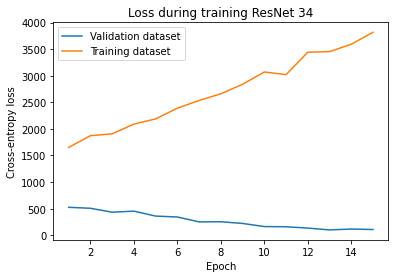

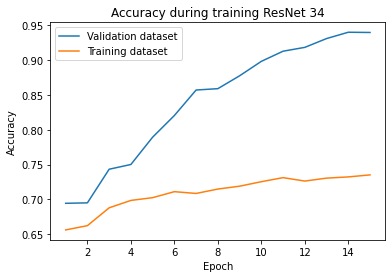

Best training accuracy: 0.7353186172428154
Best validation accuracy: 0.9400712666018789


In [21]:
plot_losses('ResNet 34', validation_losses_resnet, training_losses_resnet)
plot_accuracies('ResNet 34', validation_accuracies_resnet, training_accuracies_resnet)

In [22]:
def evaluate(model, criterion, loader):
  total_loss = 0
  total_correct = 0
  total_count = 0
  for batch in tqdm(loader):
    inputs, labels = batch
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    total_loss += loss.item()
    count =  torch.eq(torch.argmax(outputs.data, dim=1), labels).sum().item()
    total_correct += count
    total_count += labels.size(0)
  total_loss /= len(loader)
  total_accuracy = total_correct / total_count
  return total_loss, total_accuracy

In [23]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, shuffle=False, batch_size=batch_size, **kwargs)
test_loss, test_accuracy = evaluate(resnet, criterion_resnet, test_loader)
print(f'test loss: {test_loss}, test_accuracy: {test_accuracy}')

100%|██████████| 49/49 [00:24<00:00,  2.03it/s]

test loss: 64.55690815983986, test_accuracy: 0.7466796242306446


In [ ]:
torch.save(resnet.state_dict(), "/content/drive/MyDrive/Colab Notebooks/saved_resnet34.pt")

We'll now try ResNet50

In [24]:
resnet50 = models.resnet50(pretrained=True)
in_count = resnet50.fc.in_features
for param in resnet50.parameters():
    param.requires_grad = False
resnet50.fc = nn.Sequential(
    nn.Linear(in_count, len(labels)),
    nn.LogSoftmax(dim=1)
)
resnet50 = resnet50.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [25]:
batch_size = 64
trainloader_resnet50 = torch.utils.data.DataLoader(dataset=train_dataset, shuffle=True, batch_size=batch_size, **kwargs)
validationloader_resnet50 = torch.utils.data.DataLoader(dataset=validation_dataset, shuffle=False, batch_size=batch_size, **kwargs)

criterion_resnet50 = nn.CrossEntropyLoss()
optimizer_resnet50 = optim.SGD(resnet50.parameters(), lr=0.001, momentum=0, weight_decay=0.0001)

In [27]:
validation_losses_resnet50, validation_accuracies_resnet50 = train(resnet50, criterion_resnet50, optimizer_resnet50, validationloader_resnet50, 15)

100%|██████████| 49/49 [00:27<00:00,  1.81it/s]


epoch: 1, loss: 286.60161716110855, accuracy: 0.06349206349206349


100%|██████████| 49/49 [00:26<00:00,  1.87it/s]


epoch: 2, loss: 182.8259919443909, accuracy: 0.5231616456106252


100%|██████████| 49/49 [00:26<00:00,  1.87it/s]


epoch: 3, loss: 77.4556172496202, accuracy: 0.7884677680596048


100%|██████████| 49/49 [00:25<00:00,  1.89it/s]


epoch: 4, loss: 34.46796538361481, accuracy: 0.8791707159054097


100%|██████████| 49/49 [00:25<00:00,  1.90it/s]


epoch: 5, loss: 23.635902797119044, accuracy: 0.8905085843861354


100%|██████████| 49/49 [00:25<00:00,  1.90it/s]


epoch: 6, loss: 18.487490574240077, accuracy: 0.9154518950437318


100%|██████████| 49/49 [00:25<00:00,  1.90it/s]


epoch: 7, loss: 15.488121767594878, accuracy: 0.9280855199222546


100%|██████████| 49/49 [00:28<00:00,  1.71it/s]


epoch: 8, loss: 13.464099365369682, accuracy: 0.9394233884029802


100%|██████████| 49/49 [00:26<00:00,  1.88it/s]


epoch: 9, loss: 11.420949824508375, accuracy: 0.9478458049886621


100%|██████████| 49/49 [00:28<00:00,  1.72it/s]


epoch: 10, loss: 9.742941642572095, accuracy: 0.9604794298671849


100%|██████████| 49/49 [00:26<00:00,  1.87it/s]


epoch: 11, loss: 8.329056481553398, accuracy: 0.9682539682539683


100%|██████████| 49/49 [00:26<00:00,  1.86it/s]


epoch: 12, loss: 6.892960390319711, accuracy: 0.9766763848396501


100%|██████████| 49/49 [00:26<00:00,  1.87it/s]


epoch: 13, loss: 5.674668855227147, accuracy: 0.9831551668286362


100%|██████████| 49/49 [00:26<00:00,  1.87it/s]


epoch: 14, loss: 4.593162559141668, accuracy: 0.9863945578231292


100%|██████████| 49/49 [00:26<00:00,  1.87it/s]

epoch: 15, loss: 3.713474129307338, accuracy: 0.9902818270165209


In [30]:
training_losses_resnet50, training_accuracies_resnet50 = train(resnet50, criterion_resnet50, optimizer_resnet50, trainloader_resnet50, 15)

100%|██████████| 226/226 [02:07<00:00,  1.77it/s]


epoch: 1, loss: 162.0617033063838, accuracy: 0.7025544911842287


100%|██████████| 226/226 [02:06<00:00,  1.78it/s]


epoch: 2, loss: 190.3610502597505, accuracy: 0.716715257531584


100%|██████████| 226/226 [02:06<00:00,  1.78it/s]


epoch: 3, loss: 211.5608780362965, accuracy: 0.7222684992364292


100%|██████████| 226/226 [02:06<00:00,  1.79it/s]


epoch: 4, loss: 234.6947571295025, accuracy: 0.7289323892822435


100%|██████████| 226/226 [02:05<00:00,  1.81it/s]


epoch: 5, loss: 254.41543711233982, accuracy: 0.7365680966264057


100%|██████████| 226/226 [02:05<00:00,  1.79it/s]


epoch: 6, loss: 255.3616939519359, accuracy: 0.7540608079966681


100%|██████████| 226/226 [02:06<00:00,  1.79it/s]


epoch: 7, loss: 286.9067264088487, accuracy: 0.7528807441343884


100%|██████████| 226/226 [02:06<00:00,  1.79it/s]


epoch: 8, loss: 282.7400831712031, accuracy: 0.7602387893933084


100%|██████████| 226/226 [02:05<00:00,  1.79it/s]


epoch: 9, loss: 294.40826333307587, accuracy: 0.771622934888241


100%|██████████| 226/226 [02:04<00:00,  1.81it/s]


epoch: 10, loss: 308.9131308994462, accuracy: 0.7707899486325143


100%|██████████| 226/226 [02:05<00:00,  1.80it/s]


epoch: 11, loss: 322.8529175467196, accuracy: 0.7748854643898375


100%|██████████| 226/226 [02:05<00:00,  1.81it/s]


epoch: 12, loss: 340.1255151529228, accuracy: 0.7735665694849369


100%|██████████| 226/226 [02:04<00:00,  1.81it/s]


epoch: 13, loss: 344.85677968084286, accuracy: 0.7779397473275025


100%|██████████| 226/226 [02:04<00:00,  1.81it/s]


epoch: 14, loss: 362.37934063599175, accuracy: 0.781202276829099


100%|██████████| 226/226 [02:04<00:00,  1.82it/s]

epoch: 15, loss: 366.11396582780685, accuracy: 0.7822435096487574


In [31]:
testloader_resnet50 = torch.utils.data.DataLoader(dataset=test_dataset, shuffle=False, batch_size=batch_size, **kwargs)
test_loss, test_accuracy = evaluate(resnet50, criterion_resnet50, testloader_resnet50)
print(f'test loss: {test_loss}, test_accuracy: {test_accuracy}')

100%|██████████| 49/49 [00:26<00:00,  1.88it/s]

test loss: 5.481612203072529, test_accuracy: 0.8150307742144477


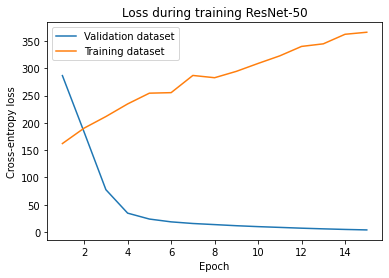

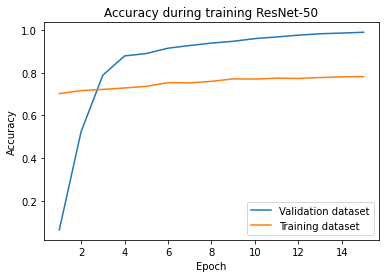

Best training accuracy: 0.7822435096487574
Best validation accuracy: 0.9902818270165209


In [33]:
plot_losses('ResNet-50', validation_losses_resnet50, training_losses_resnet50)
plot_accuracies('ResNet-50', validation_accuracies_resnet50, training_accuracies_resnet50)

Now we will try Inception V3

In [43]:
inception_data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomRotation(degrees=30),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}

train_dataset_inception = TransformedDataset(train_images, inception_data_transforms['train'])
validation_dataset_inception = TransformedDataset(validation_images, inception_data_transforms['validation'])
test_dataset_inception = TransformedDataset(test_images, inception_data_transforms['test'])

batch_size = 64
inception_train_loader = torch.utils.data.DataLoader(dataset=train_dataset_inception, shuffle=True, batch_size=batch_size, **kwargs)
inception_validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset_inception, shuffle=False, batch_size=batch_size, **kwargs)
inception_test_loader = torch.utils.data.DataLoader(dataset=test_dataset_inception, shuffle=False, batch_size=batch_size, **kwargs)

inception_model = models.inception_v3(pretrained=True)
inception_model.aux_logits = False
in_count = inception_model.fc.in_features

for param in inception_model.parameters():
    param.requires_grad = False
    inception_model.fc = nn.Sequential(
      nn.Linear(in_count, len(labels)),
      nn.LogSoftmax(dim=1)
    )
in_count = inception_model.AuxLogits.fc.in_features
inception_model.AuxLogits.fc = nn.Sequential(
    nn.Linear(in_count, len(labels)),
    nn.LogSoftmax(dim=1)
)

inception_model = inception_model.to(device)

In [48]:
inception_criterion = nn.CrossEntropyLoss()
inception_optimizer = optim.SGD(inception_model.parameters(), lr=0.01, momentum=0.0, weight_decay=0.0001)
# inception_optimizer = optim.Adam(inception_model.parameters(), lr=0.01, weight_decay=0.0001)
os.environ['WANDB_CONSOLE'] = 'off'
inception_validation_losses, inception_validation_accuracies = train(inception_model, inception_criterion, inception_optimizer, inception_validation_loader, 15)

100%|██████████| 49/49 [00:28<00:00,  1.69it/s]


epoch: 1, loss: 1419.677802261041, accuracy: 0.9099449303530937


100%|██████████| 49/49 [00:28<00:00,  1.69it/s]


epoch: 2, loss: 1283.3864783462213, accuracy: 0.92095885973437


100%|██████████| 49/49 [00:29<00:00,  1.64it/s]


epoch: 3, loss: 1188.2266013476312, accuracy: 0.9203109815354713


100%|██████████| 49/49 [00:29<00:00,  1.69it/s]


epoch: 4, loss: 945.5475892631375, accuracy: 0.9342403628117913


100%|██████████| 49/49 [00:28<00:00,  1.70it/s]


epoch: 5, loss: 926.7354302163027, accuracy: 0.938127632005183


100%|██████████| 49/49 [00:29<00:00,  1.67it/s]


epoch: 6, loss: 841.2344829829372, accuracy: 0.9433106575963719


100%|██████████| 49/49 [00:29<00:00,  1.69it/s]


epoch: 7, loss: 770.1865956831952, accuracy: 0.9420149011985747


100%|██████████| 49/49 [00:28<00:00,  1.69it/s]


epoch: 8, loss: 727.7968022670901, accuracy: 0.9471979267897636


100%|██████████| 49/49 [00:29<00:00,  1.69it/s]


epoch: 9, loss: 708.1391527117515, accuracy: 0.9446064139941691


100%|██████████| 49/49 [00:28<00:00,  1.69it/s]


epoch: 10, loss: 772.0575832444795, accuracy: 0.949789439585358


100%|██████████| 49/49 [00:28<00:00,  1.69it/s]


epoch: 11, loss: 887.0810464352977, accuracy: 0.9420149011985747


100%|██████████| 49/49 [00:28<00:00,  1.70it/s]


epoch: 12, loss: 913.494332060522, accuracy: 0.9400712666018789


100%|██████████| 49/49 [00:28<00:00,  1.70it/s]


epoch: 13, loss: 917.4213733615316, accuracy: 0.9407191448007775


100%|██████████| 49/49 [00:28<00:00,  1.70it/s]


epoch: 14, loss: 865.0015958669235, accuracy: 0.9400712666018789


100%|██████████| 49/49 [00:29<00:00,  1.68it/s]

epoch: 15, loss: 897.959404458805, accuracy: 0.9504373177842566


In [49]:
inception_losses, inception_accuracies = train(inception_model, inception_criterion, inception_optimizer, inception_train_loader, 15)

100%|██████████| 226/226 [02:14<00:00,  1.68it/s]


epoch: 1, loss: 14621.261232899353, accuracy: 0.6443842843259753


100%|██████████| 226/226 [02:14<00:00,  1.68it/s]


epoch: 2, loss: 13856.284698756395, accuracy: 0.661668749132306


100%|██████████| 226/226 [02:14<00:00,  1.68it/s]


epoch: 3, loss: 14829.067953464204, accuracy: 0.659447452450368


100%|██████████| 226/226 [02:14<00:00,  1.68it/s]


epoch: 4, loss: 15774.172332561122, accuracy: 0.6547271970012495


100%|██████████| 226/226 [02:15<00:00,  1.67it/s]


epoch: 5, loss: 15121.554760688174, accuracy: 0.6768013327780091


100%|██████████| 226/226 [02:14<00:00,  1.68it/s]


epoch: 6, loss: 15214.71446754658, accuracy: 0.6760377620435929


100%|██████████| 226/226 [02:14<00:00,  1.68it/s]


epoch: 7, loss: 15620.221762057954, accuracy: 0.6820074968763016


100%|██████████| 226/226 [02:14<00:00,  1.68it/s]


epoch: 8, loss: 15605.854354723366, accuracy: 0.6898514507843954


100%|██████████| 226/226 [02:14<00:00,  1.68it/s]


epoch: 9, loss: 15423.635904227738, accuracy: 0.693738719977787


100%|██████████| 226/226 [02:14<00:00,  1.68it/s]


epoch: 10, loss: 15529.876082293755, accuracy: 0.6945717062335138


100%|██████████| 226/226 [02:14<00:00,  1.68it/s]


epoch: 11, loss: 15729.03309833898, accuracy: 0.693738719977787


100%|██████████| 226/226 [02:14<00:00,  1.68it/s]


epoch: 12, loss: 15658.03167562569, accuracy: 0.7045675413022352


100%|██████████| 226/226 [02:14<00:00,  1.68it/s]


epoch: 13, loss: 15610.639673823804, accuracy: 0.703318061918645


100%|██████████| 226/226 [02:14<00:00,  1.68it/s]


epoch: 14, loss: 15481.894784167804, accuracy: 0.7074829931972789


100%|██████████| 226/226 [02:14<00:00,  1.68it/s]

epoch: 15, loss: 16083.749603271484, accuracy: 0.7084548104956269


In [53]:
test_loss, test_accuracy = evaluate(inception_model, inception_criterion, inception_test_loader)
print(f'inception test loss: {test_loss}, test accuracy: {test_accuracy}')

  0%|          | 0/49 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7feaed78bcb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7feaed78bcb0>
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test 

inception test loss: 223.8664720496353, test accuracy: 0.7576935536119209


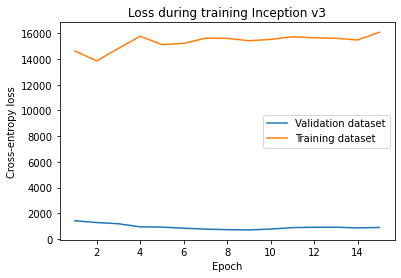

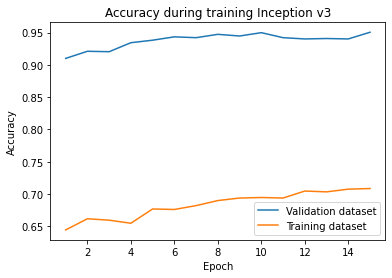

Best training accuracy: 0.7084548104956269
Best validation accuracy: 0.9504373177842566


In [52]:
plot_losses('Inception v3', inception_validation_losses, inception_losses)
plot_accuracies('Inception v3', inception_validation_accuracies, inception_accuracies)

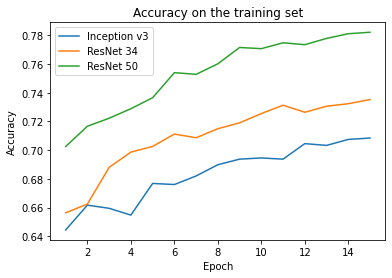

In [54]:
plt.title('Accuracy on the training set')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
epochs = list(range(1, 16))
plt.plot(epochs, inception_accuracies, label='Inception v3')
plt.plot(epochs, training_accuracies_resnet, label='ResNet 34')
plt.plot(epochs, training_accuracies_resnet50, label='ResNet 50')
plt.legend()
plt.show()

In [ ]:
torch.save(inception_model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/saved_inception.pt")